In [187]:
import pandas as pd

url ='https://raw.githubusercontent.com/OlhaDot/NewProjectStadyAcademy/master/cardox.csv'
data = pd.read_csv(url,delimiter=',' )

In [188]:
# 1.Проведіть попередній аналіз даних
print(data)

print(data.describe())

print(data.isnull().sum())

           date   value
0    1958-03-01  315.71
1    1958-04-01  317.45
2    1958-05-01  317.50
3    1958-06-01  317.10
4    1958-07-01  315.86
..          ...     ...
724  2018-07-01  408.71
725  2018-08-01  406.99
726  2018-09-01  405.51
727  2018-10-01  406.00
728  2018-11-01  408.02

[729 rows x 2 columns]
            value
count  729.000000
mean   353.787229
std     27.547500
min    312.660000
25%    328.570000
50%    351.410000
75%    375.990000
max    411.240000
date     0
value    0
dtype: int64


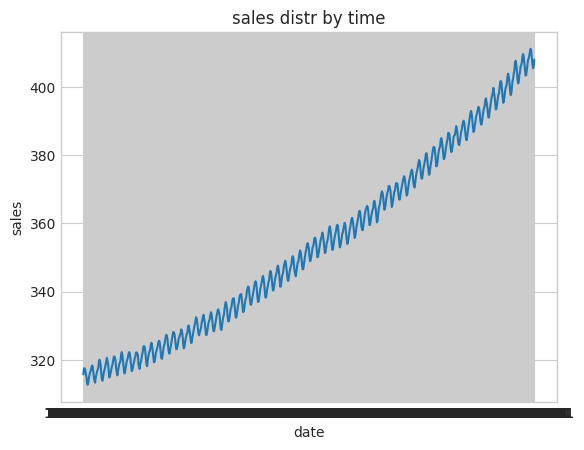

In [189]:
import matplotlib.pyplot as plt

plt.plot(data['date'], data['value'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('sales distr by time')
plt.show()



Text(0.5, 1.0, 'anomalies')

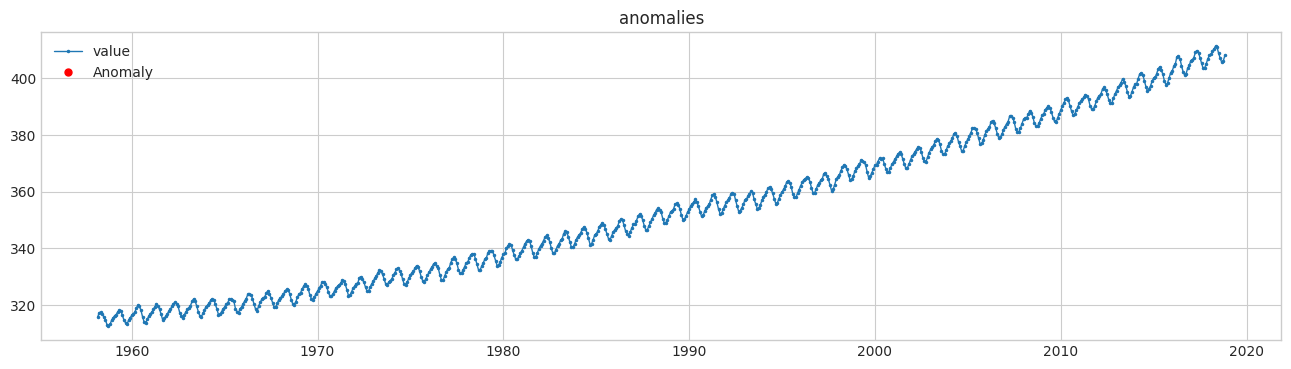

In [190]:
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)


from adtk.visualization import plot
from adtk.detector import ThresholdAD

threshold_ad = ThresholdAD(high=500, low=300)
anomalies = threshold_ad.detect(data['value'])

plot(data['value'], anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.title('anomalies')

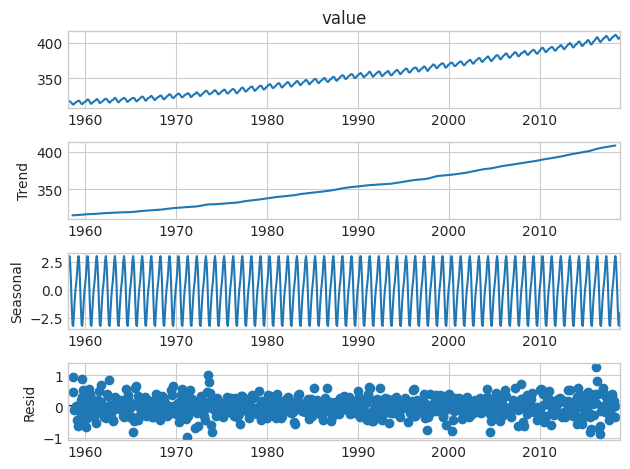

In [191]:
# 3.Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і. т. і.)
from statsmodels.tsa.seasonal import seasonal_decompose

result_additive = seasonal_decompose(data['value'], model='additive', period=12)
result_additive.plot()
plt.show()

# seasonalaty - yes
# no need tocorrections

In [209]:
# 4. Оберіть модель і проведіть оцінку її метрик

train = data[:540]
test = data[540:]

print(train)
# print(train['date'])

# print(test)

             value
date              
1958-03-01  315.71
1958-04-01  317.45
1958-05-01  317.50
1958-06-01  317.10
1958-07-01  315.86
...            ...
2002-10-01  370.55
2002-11-01  372.25
2002-12-01  373.79
2003-01-01  374.88
2003-02-01  375.64

[540 rows x 1 columns]


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


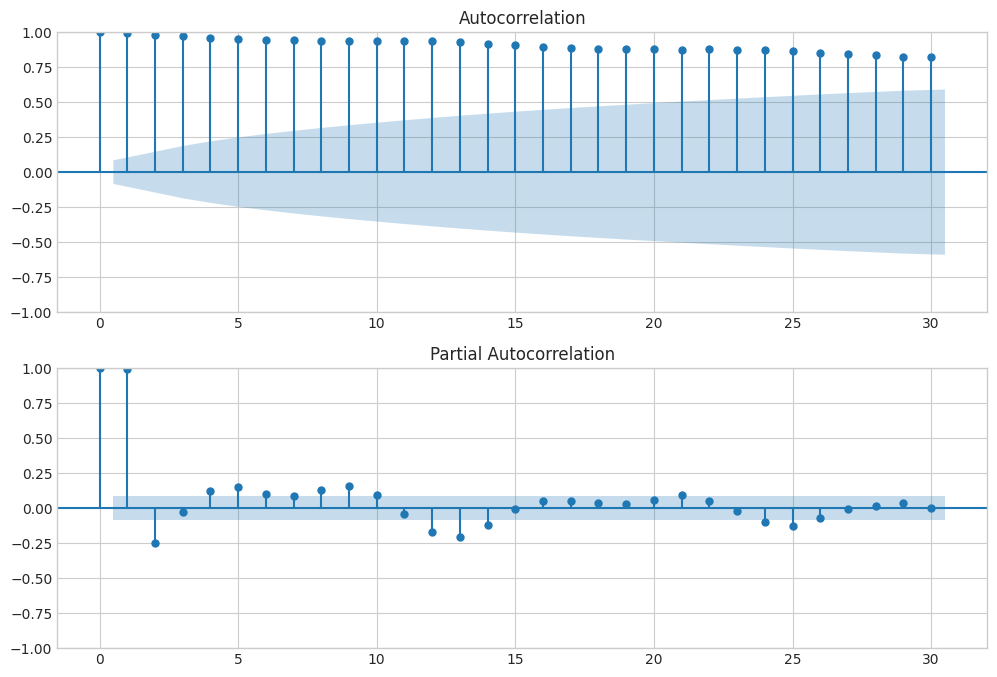

In [193]:
# Оберіть модель і проведіть оцінку її метрик -arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train['value'], lags=30, ax=ax[0])
plot_pacf(train['value'], lags=30, ax=ax[1])
plt.show()

# downward trend for autocorrelation and part correl is the biggest for 1,2 lags


In [198]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train['value'], order=(1,1,1), seasonal_order=(0, 1, 1, 12))
fit_model = model.fit()
forecast = fit_model.forecast(steps=len(test))


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [199]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test['value'], forecast)
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(forecast - test['value']) / np.abs(test['value']))
print('MSE:', mse)
print('MAE:', mae)
print('RMSE:', rmse)
print('MAPE:', mape)

#  ok


MSE: 13.58431088110523
MAE: 2.975936929526752
RMSE: 3.6856900142449893
MAPE: 0.007470304024071662


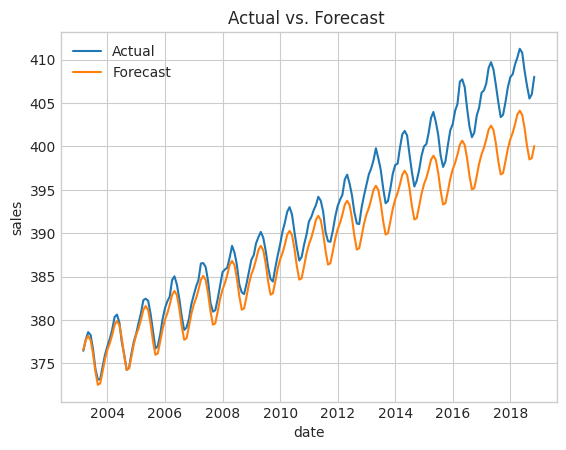

In [200]:
# 5.Проведіть кінцеву діагностику для отриманої моделі
plt.plot(test.index, test['value'], label='Actual')
plt.plot(test.index, forecast, label='Forecast')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Actual vs. Forecast ')
plt.legend()
plt.show()


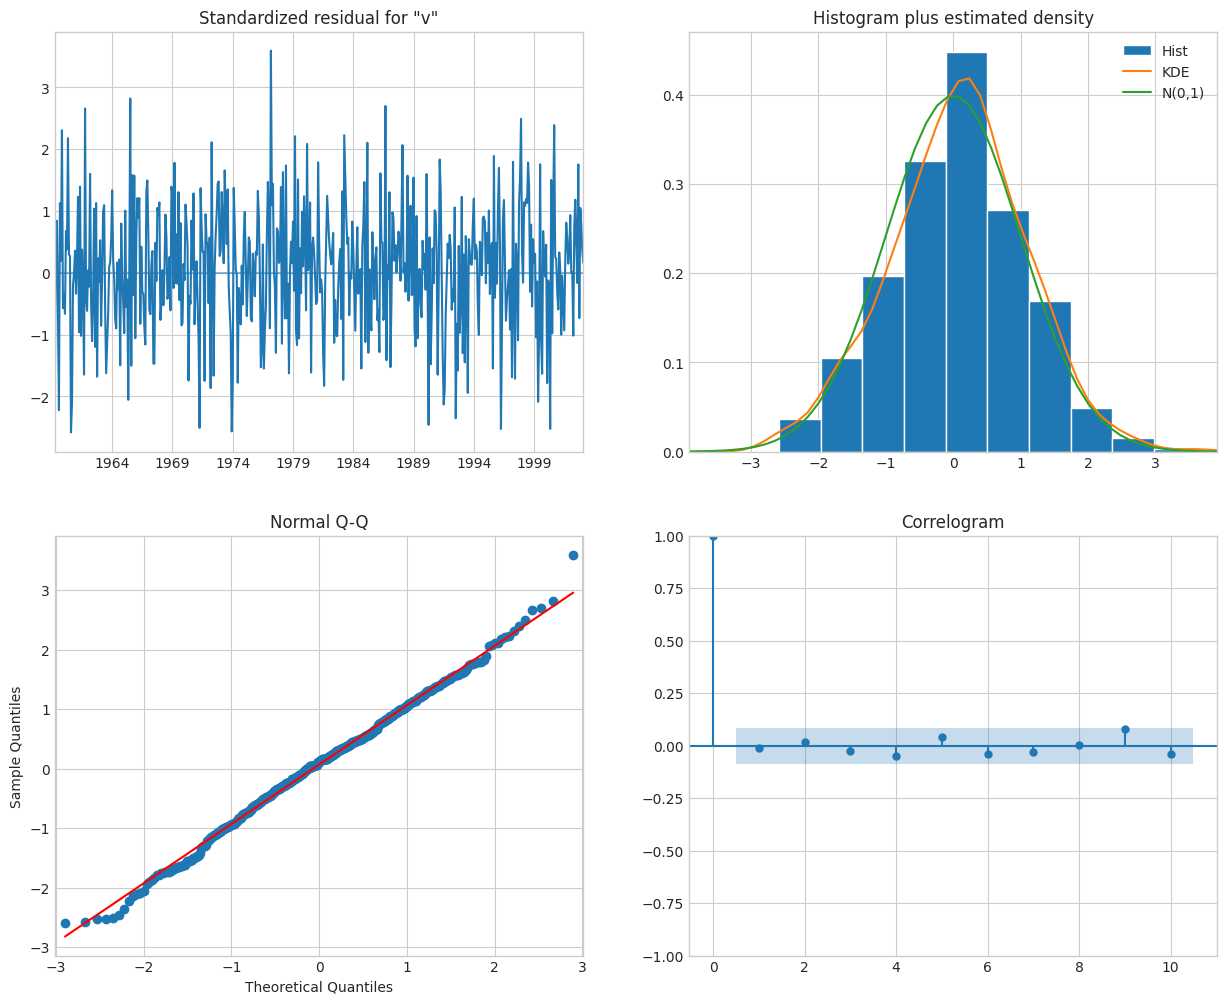

In [201]:
fit_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [202]:
predict=fit_model.get_prediction()
predict.predicted_mean[:10]

1958-03-01      0.000000
1958-04-01    315.709992
1958-05-01    317.449999
1958-06-01    317.500000
1958-07-01    317.100000
1958-08-01    315.860000
1958-09-01    314.930000
1958-10-01    313.200000
1958-11-01    312.660000
1958-12-01    313.330000
Freq: MS, Name: predicted_mean, dtype: float64

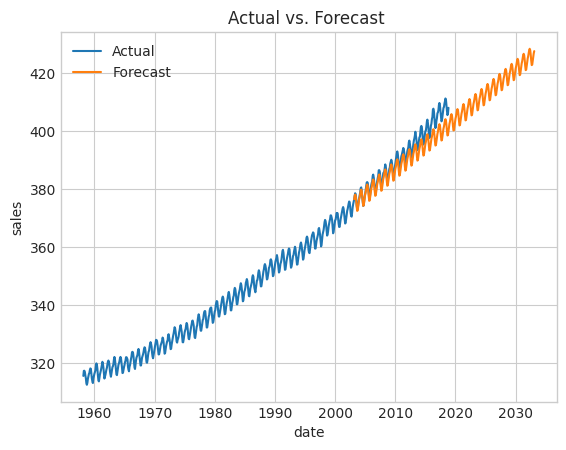

In [210]:
# 6.Виконайте прогноз на 30 років

forecast = fit_model.forecast(steps=360)

plt.plot(data['value'], label='Actual')
plt.plot( forecast, label='Forecast')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Actual vs. Forecast ')
plt.legend()
plt.show()

In [211]:
forecast.to_csv('forecast.csv', header=['value'])